In [1]:
import os
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
import albumentations as A
import random
import wandb

/media/HDD/fdittaro/env/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
wandb.login()

wandb: Currently logged in as: federico-dittaro (federico-dittaro-university-of-udine) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
""" name="run_my_id" """
wandb.init(
    project="CropAndWeed_dataset-segmentation",
    name=f"run_CropAndWeed_seg_MNV2+DeepLabV3",
    config={
        "epochs": 25,
        "batch_size": 8
    }
)

In [2]:
"""Divisione del dataset in 70% training, 15% validation e 15% test"""
images_dir = "../../cropandweed-dataset/images"

all_ids = [f for f in os.listdir(images_dir) if f.endswith(".jpg")]
total = len(all_ids)

random.seed(42)
random.shuffle(all_ids)

train_size = int(total * 0.70)
val_size = int(total * 0.15)
test_size = total - train_size - val_size

train_ids = all_ids[:train_size]
val_ids = all_ids[train_size:train_size + val_size]
test_ids = all_ids[train_size + val_size:]

print(f"Training set: {len(train_ids)} immagini")
print(f"Validation set: {len(val_ids)} immagini")
print(f"Test set: {len(test_ids)} immagini")

Training set: 5623 immagini
Validation set: 1205 immagini
Test set: 1206 immagini


In [3]:
class CropAndWeedDataset(Dataset):
    """
    image_ids: lista degli ID immagine
    images_dir: cartella dove si trovano le immagini
    masks_dir: cartella dove si trovano le maschere corrispondenti
    transform: trasformazioni da applicare
    """
    def __init__(self, image_ids, images_dir, masks_dir, transform=None):
        self.image_ids = image_ids 
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        
    """ Restituisce la lunghezza del dataset (necessario per PyTorch DataLoader)."""
    def __len__(self):
        return len(self.image_ids)
    
    """Dato un indice recupera la coppia (immagine, maschera), applica trasformazioni coerenti ad entrambi
    e le converte in tensori Pytorch. La label con id 255 viene rimappata come 100."""
    def __getitem__(self, idx):
        img_filename = self.image_ids[idx]
        img_path = os.path.join(self.images_dir, img_filename)

        mask_filename = os.path.splitext(img_filename)[0] + ".png"
        mask_path = os.path.join(self.masks_dir, mask_filename)

        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        image = torch.tensor(np.array(image) / 255.0, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(np.array(mask), dtype=torch.long)

        mask[mask == 255] = 100

        return image, mask

train_transform = A.Compose([A.Resize(256, 256)])
val_transform = A.Compose([A.Resize(256, 256)])
test_transform = A.Compose([A.Resize(256, 256)])

train_loader = DataLoader(
    CropAndWeedDataset(train_ids, "../../cropandweed-dataset/images", "../../cropandweed-dataset/labelIds/CropAndWeed", transform=train_transform),
    batch_size=8, shuffle=True
)

val_loader = DataLoader(
    CropAndWeedDataset(val_ids, "../../cropandweed-dataset/images", "../../cropandweed-dataset/labelIds/CropAndWeed", transform=val_transform),
    batch_size=8, shuffle=False
)

test_loader = DataLoader(
    CropAndWeedDataset(test_ids, "../../cropandweed-dataset/images", "../../cropandweed-dataset/labelIds/CropAndWeed", transform=test_transform),
    batch_size=8, shuffle=False
)

In [4]:
"""Costruzione del modello DeepLabV3 con MobileNetV2 come backbone. Il modello carica pesi pre-addestrati su ImageNet
per l'encoder. Le immagini in input hanno tre canali (RGB) e 101 classi di output (una per ciascuna classe di
segmentazione)"""
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = smp.DeepLabV3(
    encoder_name="mobilenet_v2",
    encoder_weights="imagenet",
    in_channels=3,
    classes=101
)

num_params = count_parameters(model)
print(f" Numero di parametri allenabili: {num_params:,}")

 Numero di parametri allenabili: 12,673,637


In [5]:
"""Imposta il dispositivo di calcolo sulla GPU e sposta il modello sul dispositivo. 
Utilizza la Cross Entropy Loss come funzione di perdita e Adam come ottimizzatore con leraning rate 0.001"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
"""Calcolo dell'IoU:
- intersection: numero di pixel correttamente classificati per quella classe
- union: tutti i pixel predetti o etichettati come quella classe
Restituisce la media delle IoU tra tutte le classi, ignorando i nan (classe non presente nè nella predizione
nè nella label)"""
def compute_iou(preds, labels, num_classes):
    preds = torch.argmax(preds, dim=1).view(-1)
    labels = labels.view(-1)
    ious = []
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = labels == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return torch.tensor(ious).nanmean().item()

In [10]:
"""Cacolo dei pixel correttamente classificati"""
def compute_pixel_accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1)
    return (preds == labels).float().mean().item()

In [11]:
"""Addestramento del modello per una singola epoca"""
def train_one_epoch(model, dataloader, loss_fn, optimizer):
    model.train()
    running_loss = 0
    for images, masks in tqdm(dataloader, desc="Training"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

"""Valuta il modello su un dataloader di validazione (senza l'aggiornamento dei pesi)"""
def validate(model, dataloader, loss_fn):
    model.eval()
    val_loss = 0
    iou_total = 0
    acc_total = 0
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()
            iou_total += compute_iou(outputs, masks, num_classes=19)
            acc_total += compute_pixel_accuracy(outputs, masks)
    return val_loss / len(dataloader), iou_total / len(dataloader), acc_total / len(dataloader)

In [12]:
"""Addestra il modello per 25 epoche salvando il modello migliore. L'addestramento si interrompe se per 5 epoche
non avviene nessun miglioramento."""
num_epochs = 25
best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss = train_one_epoch(model, train_loader, loss_fn, optimizer)
    val_loss, val_iou, val_acc = validate(model, val_loader, loss_fn)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | IoU: {val_iou:.4f} | Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "../MNV2+DeepLabV3_models/MBV2DeepLabV3_CropAndWeed_segmentation.pth")
        print("✅ Model saved.")
        counter = 0
    else:
        counter += 1
        print(f"No improvement. EarlyStopping counter: {counter}/{patience}")
        if counter >= patience:
            print("⏹️ Early stopping triggered.")
            break
    wandb.log({
        "train_loss": train_loss,
        "val_loss": val_loss,
        "val_iou": val_iou,
        "val_acc": val_acc
    })
wandb.finish()


Epoch 1/25


Validation: 100%|█████████████████████████████████████████████████████████████████████| 151/151 [00:29<00:00,  5.19it/s]


Train Loss: 0.2381 | Val Loss: 0.1462 | IoU: 0.2380 | Acc: 0.9671
✅ Model saved.

Epoch 2/25


Validation: 100%|█████████████████████████████████████████████████████████████████████| 151/151 [00:29<00:00,  5.19it/s]


Train Loss: 0.1391 | Val Loss: 0.1310 | IoU: 0.2579 | Acc: 0.9687
✅ Model saved.

Epoch 3/25


Validation: 100%|█████████████████████████████████████████████████████████████████████| 151/151 [00:29<00:00,  5.20it/s]


Train Loss: 0.1281 | Val Loss: 0.1232 | IoU: 0.2182 | Acc: 0.9695
✅ Model saved.

Epoch 4/25


Validation: 100%|█████████████████████████████████████████████████████████████████████| 151/151 [00:29<00:00,  5.20it/s]


Train Loss: 0.1220 | Val Loss: 0.1345 | IoU: 0.2202 | Acc: 0.9677
No improvement. EarlyStopping counter: 1/5

Epoch 5/25


Validation: 100%|█████████████████████████████████████████████████████████████████████| 151/151 [00:29<00:00,  5.20it/s]


Train Loss: 0.1168 | Val Loss: 0.1111 | IoU: 0.2574 | Acc: 0.9710
✅ Model saved.

Epoch 6/25


Validation: 100%|█████████████████████████████████████████████████████████████████████| 151/151 [00:29<00:00,  5.18it/s]


Train Loss: 0.1119 | Val Loss: 0.1033 | IoU: 0.2607 | Acc: 0.9726
✅ Model saved.

Epoch 7/25


Validation: 100%|█████████████████████████████████████████████████████████████████████| 151/151 [00:29<00:00,  5.17it/s]


Train Loss: 0.1076 | Val Loss: 0.1020 | IoU: 0.2132 | Acc: 0.9721
✅ Model saved.

Epoch 8/25


Validation: 100%|█████████████████████████████████████████████████████████████████████| 151/151 [00:29<00:00,  5.20it/s]


Train Loss: 0.1039 | Val Loss: 0.0993 | IoU: 0.2550 | Acc: 0.9725
✅ Model saved.

Epoch 9/25


Validation: 100%|█████████████████████████████████████████████████████████████████████| 151/151 [00:29<00:00,  5.20it/s]


Train Loss: 0.1012 | Val Loss: 0.0969 | IoU: 0.2725 | Acc: 0.9742
✅ Model saved.

Epoch 10/25


Validation: 100%|█████████████████████████████████████████████████████████████████████| 151/151 [00:29<00:00,  5.20it/s]


Train Loss: 0.0963 | Val Loss: 0.0966 | IoU: 0.2848 | Acc: 0.9733
✅ Model saved.

Epoch 11/25


Validation: 100%|█████████████████████████████████████████████████████████████████████| 151/151 [00:29<00:00,  5.19it/s]


Train Loss: 0.0965 | Val Loss: 0.0967 | IoU: 0.2411 | Acc: 0.9739
No improvement. EarlyStopping counter: 1/5

Epoch 12/25


Validation: 100%|█████████████████████████████████████████████████████████████████████| 151/151 [00:29<00:00,  5.19it/s]


Train Loss: 0.0921 | Val Loss: 0.0908 | IoU: 0.2784 | Acc: 0.9749
✅ Model saved.

Epoch 13/25


Validation: 100%|█████████████████████████████████████████████████████████████████████| 151/151 [00:29<00:00,  5.20it/s]


Train Loss: 0.0888 | Val Loss: 0.0966 | IoU: 0.3045 | Acc: 0.9742
No improvement. EarlyStopping counter: 1/5

Epoch 14/25


Validation: 100%|█████████████████████████████████████████████████████████████████████| 151/151 [00:29<00:00,  5.20it/s]


Train Loss: 0.0863 | Val Loss: 0.0855 | IoU: 0.2744 | Acc: 0.9762
✅ Model saved.

Epoch 15/25


Validation: 100%|█████████████████████████████████████████████████████████████████████| 151/151 [00:29<00:00,  5.18it/s]


Train Loss: 0.0862 | Val Loss: 0.0874 | IoU: 0.2567 | Acc: 0.9750
No improvement. EarlyStopping counter: 1/5

Epoch 16/25


Validation: 100%|█████████████████████████████████████████████████████████████████████| 151/151 [00:29<00:00,  5.19it/s]


Train Loss: 0.0838 | Val Loss: 0.0863 | IoU: 0.2912 | Acc: 0.9758
No improvement. EarlyStopping counter: 2/5

Epoch 17/25


Validation: 100%|█████████████████████████████████████████████████████████████████████| 151/151 [00:29<00:00,  5.17it/s]


Train Loss: 0.0797 | Val Loss: 0.0806 | IoU: 0.2746 | Acc: 0.9766
✅ Model saved.

Epoch 18/25


Validation: 100%|█████████████████████████████████████████████████████████████████████| 151/151 [00:29<00:00,  5.17it/s]


Train Loss: 0.0810 | Val Loss: 0.0794 | IoU: 0.2829 | Acc: 0.9770
✅ Model saved.

Epoch 19/25


Validation: 100%|█████████████████████████████████████████████████████████████████████| 151/151 [00:29<00:00,  5.18it/s]


Train Loss: 0.0780 | Val Loss: 0.0774 | IoU: 0.2943 | Acc: 0.9772
✅ Model saved.

Epoch 20/25


Validation: 100%|█████████████████████████████████████████████████████████████████████| 151/151 [00:29<00:00,  5.20it/s]


Train Loss: 0.0764 | Val Loss: 0.0853 | IoU: 0.2851 | Acc: 0.9759
No improvement. EarlyStopping counter: 1/5

Epoch 21/25


Validation: 100%|█████████████████████████████████████████████████████████████████████| 151/151 [00:29<00:00,  5.18it/s]


Train Loss: 0.0767 | Val Loss: 0.0777 | IoU: 0.3032 | Acc: 0.9777
No improvement. EarlyStopping counter: 2/5

Epoch 22/25


Validation: 100%|█████████████████████████████████████████████████████████████████████| 151/151 [00:29<00:00,  5.19it/s]


Train Loss: 0.0712 | Val Loss: 0.0796 | IoU: 0.3113 | Acc: 0.9769
No improvement. EarlyStopping counter: 3/5

Epoch 23/25


Validation: 100%|█████████████████████████████████████████████████████████████████████| 151/151 [00:29<00:00,  5.19it/s]


Train Loss: 0.0751 | Val Loss: 0.0838 | IoU: 0.2457 | Acc: 0.9767
No improvement. EarlyStopping counter: 4/5

Epoch 24/25


Validation: 100%|█████████████████████████████████████████████████████████████████████| 151/151 [00:29<00:00,  5.19it/s]

Train Loss: 0.0782 | Val Loss: 0.0837 | IoU: 0.2801 | Acc: 0.9758
No improvement. EarlyStopping counter: 5/5
⏹️ Early stopping triggered.


train_loss,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▂▃▁▄▅▄▅▆▅▆▆▆▇▆▇▇██▇█▇▇
val_iou,▃▄▁▂▄▄▁▄▅▆▃▆█▅▄▇▅▆▇▆▇█▃
val_loss,█▆▆▇▄▄▄▃▃▃▃▂▃▂▂▂▁▁▁▂▁▁▂
train_loss,0.07507
val_acc,0.97671
val_iou,0.24572
val_loss,0.08384


In [6]:
print("Immagini del set di test:")
for filename in test_ids:
    print(filename)

Immagini del set di test:
vwg-0380-0003.jpg
vwg-0546-0030.jpg
vwg-1335-0003.jpg
vwg-0042-0021.jpg
vwg-1224-0008.jpg
ave-0230-0021.jpg
vwg-0022-0022.jpg
ave-0339-0003.jpg
ave-0210-0013.jpg
ave-0265-0013.jpg
ave-0519-0014.jpg
vwg-0022-0005.jpg
ave-0291-0013.jpg
vwg-0706-0020.jpg
vwg-0640-0015.jpg
ave-0297-0009.jpg
ave-0295-0012.jpg
ave-0544-0009.jpg
vwg-0152-0015.jpg
ave-0540-0017.jpg
ave-0256-0014.jpg
ave-0501-0012.jpg
vwg-1238-0002.jpg
ave-0540-0004.jpg
vwg-0416-0042.jpg
ave-0181-0002.jpg
vwg-0022-0014.jpg
ave-0357-0007.jpg
vwg-0423-0001.jpg
vwg-0405-0029.jpg
vwg-0229-0014.jpg
vwg-1273-0002.jpg
vwg-1253-0018.jpg
ave-0507-0016.jpg
vwg-1265-0011.jpg
vwg-1328-0003.jpg
vwg-0783-0013.jpg
ave-0593-0018.jpg
vwg-1275-0012.jpg
ave-0265-0009.jpg
ave-0153-0007.jpg
ave-0231-0007.jpg
vwg-1285-0015.jpg
vwg-0279-0001.jpg
vwg-0644-0005.jpg
ave-0326-0013.jpg
vwg-0861-0003.jpg
ave-0063-0014.jpg
vwg-0038-0000.jpg
vwg-1279-0008.jpg
vwg-0445-0021.jpg
vwg-0802-0002.jpg
ave-0358-0026.jpg
vwg-1167-0009.jpg
vw

In [7]:
class_colors = [
    (0, 0, 0), (255, 0, 0), (234, 0, 0), (212, 0, 0), (191, 0, 0), (170, 0, 0), (149, 0, 0),
    (255, 85, 0), (234, 78, 0), (212, 71, 0), (191, 64, 0), (170, 57, 0), (149, 50, 0),
    (255, 170, 0), (255, 255, 0), (170, 255, 0), (85, 255, 0), (0, 255, 0), (0, 255, 85),
    (0, 255, 170), (0, 255, 255), (0, 170, 255), (0, 85, 255), (0, 0, 255), (85, 0, 255),
    (170, 0, 255), (255, 0, 255), (255, 0, 170), (255, 0, 85), (255, 188, 178), (255, 207, 178),
    (255, 226, 178), (255, 245, 178), (245, 255, 178), (226, 255, 178), (207, 255, 178),
    (188, 255, 178), (178, 255, 188), (178, 255, 207), (178, 255, 226), (178, 255, 245),
    (178, 245, 255), (178, 226, 255), (178, 207, 255), (178, 188, 255), (188, 178, 255),
    (207, 178, 255), (226, 178, 255), (245, 178, 255), (255, 178, 245), (255, 178, 226),
    (255, 178, 207), (255, 178, 188), (255, 194, 178), (255, 213, 178), (255, 219, 178),
    (255, 232, 178), (255, 238, 178), (255, 251, 178), (255, 212, 0), (239, 255, 178),
    (233, 255, 178), (220, 255, 178), (214, 255, 178), (201, 255, 178), (195, 255, 178),
    (182, 255, 178), (178, 255, 194), (178, 255, 200), (178, 255, 213), (178, 255, 220),
    (178, 255, 232), (178, 255, 238), (178, 255, 251), (178, 239, 255), (178, 233, 255),
    (178, 220, 255), (178, 214, 255), (178, 201, 255), (178, 195, 255), (178, 182, 255),
    (194, 178, 255), (200, 178, 255), (213, 178, 255), (219, 178, 255), (232, 178, 255),
    (238, 178, 255), (251, 178, 255), (255, 178, 239), (255, 178, 233), (255, 178, 220),
    (255, 178, 214), (212, 255, 0), (127, 255, 0), (42, 255, 0), (244, 255, 0), (159, 255, 0),
    (74, 255, 0), (10, 255, 0), (202, 255, 0), (128, 128, 128)
]

In [8]:
""" Converte una maschera di classi in un'immagine RGB creando un'immagine vuota per poi colorare 
i pixel della maschera con il colore corrispondente """
def decode_segmap(segmentation_mask):
    h, w = segmentation_mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_idx, color in enumerate(class_colors):
        color_mask[segmentation_mask == class_idx] = color
    return color_mask

In [9]:
""" Visualizza immagine, maschera originale e predetta per un dato filename. """
def show_prediction_for_image(filename, model, dataset):
    model.eval()

    try:
        idx = dataset.image_ids.index(filename)
    except ValueError:
        print(f"❌ File '{filename}' non trovato nel set di testing.")
        return

    image, mask = dataset[idx]

    image_tensor = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    img_np = image.cpu().permute(1, 2, 0).numpy()
    mask_np = mask.cpu().numpy()
    mask_rgb = decode_segmap(mask_np)
    pred_rgb = decode_segmap(pred)

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].imshow(img_np)
    axs[0].set_title(f"Immagine: {filename}")
    axs[1].imshow(mask_rgb)
    axs[1].set_title("Maschera originale (RGB)")
    axs[2].imshow(pred_rgb)
    axs[2].set_title("Maschera predetta (RGB)")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_26689/1107350632.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../MNV2+DeepLabV3_models/MBV2DeepLabV3_CropAndWeed_segm

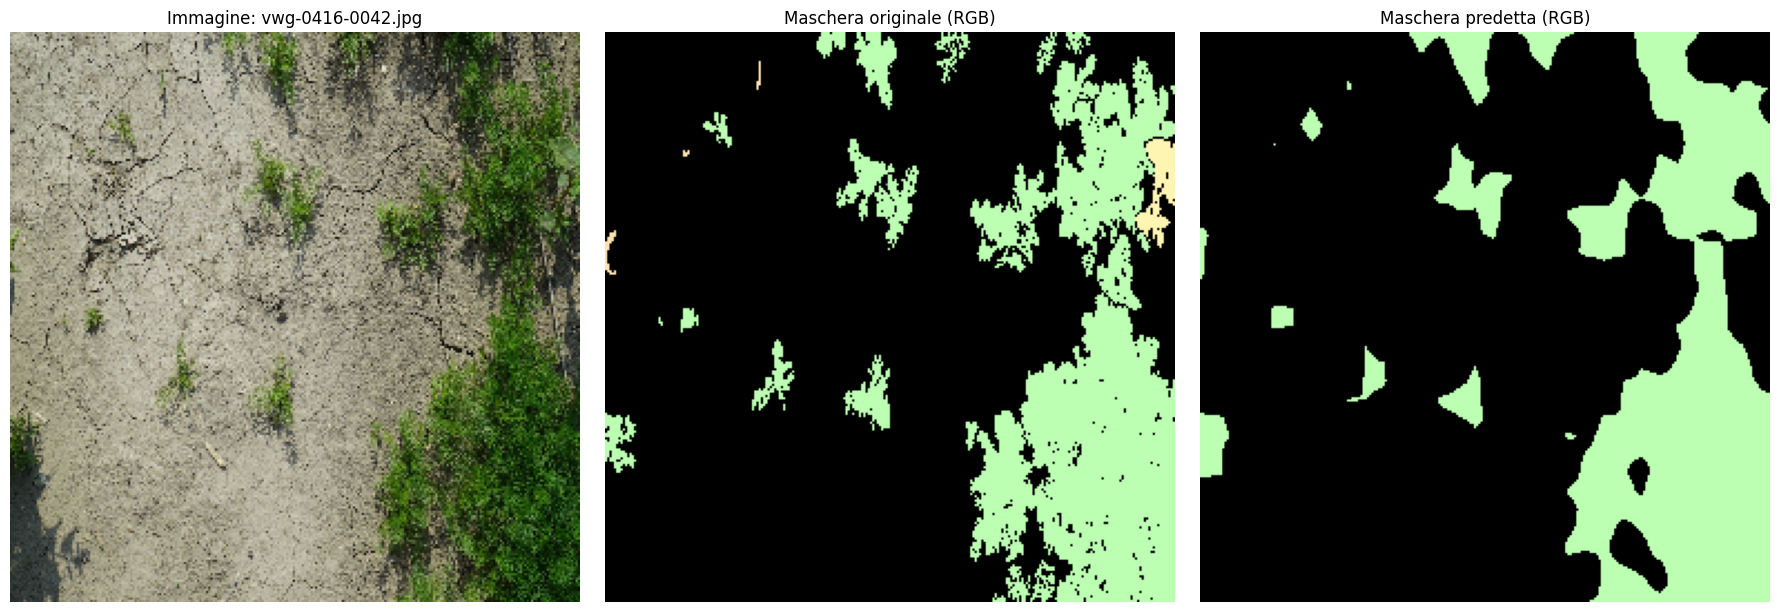

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("../MNV2+DeepLabV3_models/MBV2DeepLabV3_CropAndWeed_segmentation.pth", map_location=device))
model.to(device)

test_dataset = CropAndWeedDataset(test_ids, "../../cropandweed-dataset/images", "../../cropandweed-dataset/labelIds/CropAndWeed", transform=val_transform)

show_prediction_for_image("vwg-0416-0042.jpg", model, test_dataset)

# vwg-0416-0042.jpg   vwg-0380-0003.jpg   ave-0259-0020.jpg   ave-0540-0004.jpg   ave-0519-0009.jpg   vwg-0010-0006.jpg